# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* DPをパラメトリックに解く

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin, golden
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

### カリブレーション
* パラメータをひとつの変数にまとめる：class を使う

In [2]:
#カリブレーション
class Params:
    def __init__(self,β,γ,α,δ,nk,kmax,kmin,kgrid,maxit,tol):
        # パラメータ
        self.β = β         # 割引因子
        self.γ = γ         # 相対的危険回避度
        self.α = α         # 資本分配率 
        self.δ = δ         # 固定資本減耗
        
        # グリッド
        self.nk = nk       # 資本のグリッド数
        self.kmax = kmax   # 資本グリッドの最大値
        self.kmin = kmin   # 資本グリッドの最小値
        self.kgrid = kgrid # 資本グリッド

        # 繰り返し計算
        self.maxit = maxit # 繰り返し計算の最大値
        self.tol = tol     # 計算誤差の許容値(tolerance of error)

In [3]:
def calibration():

    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0 # 0.08

    nk = 101
    kmax = 0.5 # 固定資本減耗が0.08の場合、ここを10.0にする
    kmin = 0.05

    # numpyで等分グリッドを計算
    kgrid = np.linspace(kmin,kmax,nk)

    maxit = 1000
    tol = 1e-5 # 2.収束の基準を設定

    return Params(β, γ, α, δ, nk, kmax, kmin, kgrid, maxit, tol)

In [4]:
params = calibration();

---

## 経済学でよく使う関数

In [5]:
import MyEconFcn

---

## VFIのための準備：当て推量
* 価値関数の初期値はすべての資源を使い切った場合の効用：有限期間モデルの最終期をイメージ
    * この形である必要はまったくない

In [6]:
# 価値関数と政策関数の初期値
#pfcn0 = np.zeros(params.nk)
pfcn0 = np.copy(params.kgrid)
vfcn0 = MyEconFcn.crra(params.kgrid**params.α + (1-params.δ)*params.kgrid, params.γ) # すべてを消費する際の効用

pfcn1 = np.zeros(params.nk)
vfcn1 = np.zeros(params.nk)

# 繰り返し誤差を保存する変数を設定
# 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
dif = np.zeros((2, params.maxit))

In [7]:
# 利用可能な資産をあらかじめ計算しておく
wealth = params.kgrid**params.α + (1-params.δ)*params.kgrid

### Optimを使うための関数(ベルマン方程式)を設定

In [8]:
def BellmanEq(params,wealth,kprime,vnext):
    """
    ----------------------------------------------
    === k'を1つ与えた際にベルマン方程式の値を返す ===
    ----------------------------------------------
    <input>
    ・params: パラメータなどを含む構造体
    ・wealth: 今期利用可能な資産
    ・kprime: 次期の資本量
    ・vnext: 次期の価値関数をスプライン近似した際の係数
    <output>
    ・value: 負値にしたベルマン方程式
    """
    
    value = MyEconFcn.crra((wealth - kprime), params.γ) + params.β*vnext(kprime)
    value = -1 * value

    return value

In [9]:
# 価値関数を繰り返し計算
for it in range(params.maxit):

    # 次期の価値関数を補間
    vnext = interp1d(params.kgrid,vfcn0,kind="cubic",fill_value="extrapolate") #スプライン補間

    for i in range(params.nk):

        BellmanEq1 = lambda kprime: BellmanEq(params,wealth[i],kprime,vnext) 
        pfcn1[i] = golden(BellmanEq1,brack=(0.0,wealth[i]-1e-10)) # 最適化
        vfcn1[i] = -BellmanEq1(pfcn1[i]) # 最小値を探していたので符号を反転させる
    
    dif1 = np.max(np.abs((vfcn1-vfcn0)/vfcn0)) # 価値関数の繰り返し計算誤差
    dif2 = np.max(np.abs((pfcn1-pfcn0)/pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

    # 収束途中の繰り返し計算誤差を保存
    dif[0, it] = dif1
    dif[1, it] = dif2

    vfcn0 = np.copy(vfcn1)
    pfcn0 = np.copy(pfcn1)

    #print(f"iteration counter: {it+1}")
    #print(f"error (value): {dif1:.6f}")
    #print(f"error (policy): {dif2:.6f}")
    #print()

    if dif1 < params.tol:
        break

    if it == params.maxit-1:
        print("The model does not converge...")

---

## 計算速度を測るためにNumerical DPを関数化

In [10]:
def pdp(params):
    """
    ---------------------------------------------------------------------------------------
    === 状態変数のみ離散化して操作変数は連続的に値を取る場合の動的計画法(parametric DP)の解法 ===
        アルゴリズムの詳細は、Johnson et al. (1993)を参照
    ---------------------------------------------------------------------------------------
    <input>
    ・params: パラメータ等を含む構造体
    <output>
    ・vfcn0: 計算によって得られた価値関数
    ・pfcn0: 計算によって得られた政策関数
    ・dif: 価値関数と政策関数の繰り返し計算誤差
    """
    
    # 価値関数と政策関数の初期化
    pfcn0 = np.copy(params.kgrid)
    vfcn0 = MyEconFcn.crra(params.kgrid**params.α + (1-params.δ)*params.kgrid, params.γ) # すべてを消費する際の効用

    pfcn1 = np.zeros(params.nk)
    vfcn1 = np.zeros(params.nk)

    # 利用可能な資産をあらかじめ計算しておく
    wealth = params.kgrid**params.α + (1-params.δ)*params.kgrid

    # 繰り返し誤差を保存する変数を設定
    # 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
    dif = np.zeros((2, params.maxit))

    # 価値関数を繰り返し計算
    for it in range(params.maxit):

        # 次期の価値関数を補間
        vnext = interp1d(params.kgrid,vfcn0,kind="cubic",fill_value="extrapolate") #スプライン補間

        for i in range(params.nk):

            BellmanEq1 = lambda kprime: BellmanEq(params,wealth[i],kprime,vnext) 
            pfcn1[i] = golden(BellmanEq1,brack=(0.0,wealth[i]-1e-10)) # 最適化
            vfcn1[i] = -BellmanEq1(pfcn1[i]) # 最小値を探していたので符号を反転させる
    
        dif1 = np.max(np.abs((vfcn1-vfcn0)/vfcn0)) # 価値関数の繰り返し計算誤差
        dif2 = np.max(np.abs((pfcn1-pfcn0)/pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

        # 収束途中の繰り返し計算誤差を保存
        dif[0, it] = dif1
        dif[1, it] = dif2

        vfcn0 = np.copy(vfcn1)
        pfcn0 = np.copy(pfcn1)

        print(f"iteration counter: {it+1}")
        print(f"error (value): {dif1:.6f}")
        print(f"error (policy): {dif2:.6f}")
        print()

        if dif1 < params.tol:
            break

        if it == params.maxit-1:
            print("The model does not converge...")

    return vfcn0, pfcn0, dif

In [11]:
start = time.time()
vfcn0, pfcn0, dif = pdp(params)
end = time.time()

print(f"{end-start:.6f} seconds")

iteration counter: 1
error (value): 3.331789
error (policy): 0.674223

iteration counter: 2
error (value): 0.830022
error (policy): 0.250748

iteration counter: 3
error (value): 0.451112
error (policy): 0.067092

iteration counter: 4
error (value): 0.302298
error (policy): 0.022971

iteration counter: 5
error (value): 0.223948
error (policy): 0.008463

iteration counter: 6
error (value): 0.175997
error (policy): 0.003200

iteration counter: 7
error (value): 0.143783
error (policy): 0.001221

iteration counter: 8
error (value): 0.120717
error (policy): 0.000468

iteration counter: 9
error (value): 0.103419
error (policy): 0.000180

iteration counter: 10
error (value): 0.089981
error (policy): 0.000069

iteration counter: 11
error (value): 0.079252
error (policy): 0.000027

iteration counter: 12
error (value): 0.070496
error (policy): 0.000010

iteration counter: 13
error (value): 0.063220
error (policy): 0.000004

iteration counter: 14
error (value): 0.057082
error (policy): 0.000002

i

---

In [12]:
# 最終的な政策関数が得られてから消費関数を計算
wealth = params.kgrid**params.α + (1-params.δ)*params.kgrid
cfcn = wealth - pfcn0

In [13]:
# 政策関数を使って収束した価値関数を計算
util = np.zeros(params.nk)
valfn = np.zeros(params.nk)

for i in range(params.nk):
    cons = params.kgrid[i]**params.α + (1-params.δ)*params.kgrid[i] - pfcn0[i]
    util[i] = MyEconFcn.crra(cons, params.γ)
    valfn[i] = util[i] / (1-params.β)

In [14]:
# 解析解
AA = (1-params.β)**(-1) * (np.log(1-params.α*params.β) + ((params.α*params.β)/(1-params.α*params.β))*np.log(params.α*params.β))
BB = params.α / (1 - params.α*params.β)
v_true = AA + BB*np.log(params.kgrid)
p_true = params.α*params.β*(params.kgrid**params.α);

---

# プロット

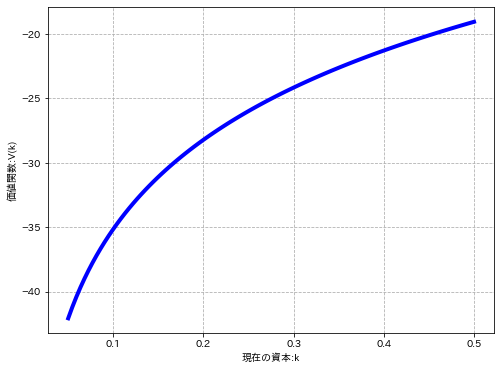

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,valfn,c="b",lw=4)
ax.set(xlabel="現在の資本:k",ylabel="価値関数:V(k)")
ax.grid(ls="--")
plt.show()

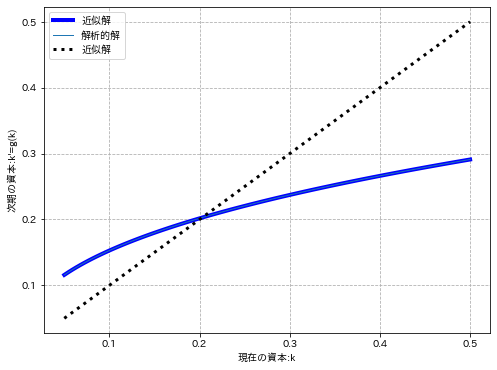

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,pfcn0,c="b",lw=4,label="近似解")
ax.plot(params.kgrid,p_true,lw=1,label="解析的解")
ax.plot(params.kgrid,params.kgrid,c="k",lw=3,ls=":",label="近似解")
ax.set(xlabel="現在の資本:k",ylabel="次期の資本:k'=g(k)")
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()

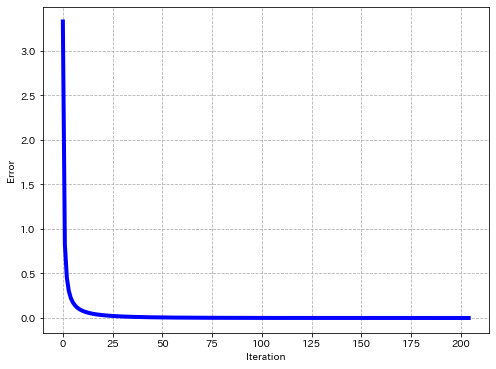

In [17]:
time = range(205)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time,dif[0,time],c="b",lw=4)
ax.set(xlabel="Iteration",ylabel="Error")
ax.grid(ls="--")
plt.show()

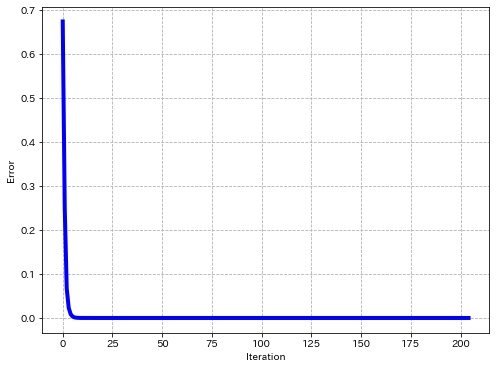

: 

In [18]:
time = range(205)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time,dif[1,time],c="b",lw=4)
ax.set(xlabel="Iteration",ylabel="Error")
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* グリッドを等分から別の方法に切り替えてみよう。
    * Hint：GenerateGrid.jl内にある関数を使ってみる。
* 所得リスクを導入してみよう。